In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from tableshift import get_dataset
from tableshift.configs.benchmark_configs import BENCHMARK_CONFIGS
from tableshift.core.tasks import _TASK_REGISTRY

from ud_bagging import UDBaggingClassifier
from ud_naive_bayes import InterpretableBernoulliNB


In [8]:
splits    = [
    'train',
    'validation',
    'id_test',
    'ood_test',
    'ood_validation'
    ]

data = [
        # [ 'ASSISTments',             'assistments'             ],
        # [ 'Childhood Lead',          'nhanes_lead'             ],
        # [ 'College Scorecard',       'college_scorecard'       ], 
        # [ 'Diabetes',                'brfss_diabetes'          ],
        # [ 'FICO HELOC',              'heloc'                   ],
        # [ 'Food Stamps',             'acsfoodstamps'           ],
        [ 'Hospital Readmission',    'diabetes_readmission'    ],    
        # [ 'Hypertension',            'brfss_blood_pressure'    ],    
        #[ 'ICU Length of Stay'       'mimic_extract_los_3'     ],    
        #[ 'ICU Mortality',           'mimic_extract_mort_hosp' ],        
        # [ 'Income',                  'acsincome'               ],
        #[ 'Public Health Insurance', 'acspubcov'               ],
        # [ 'Sepsis',                  'physionet'               ],
        # [ 'Unemployment',            'acsunemployment'         ],
        # [ 'Voting',                  'anes'                    ]
    ]


In [35]:
_TASK_REGISTRY['anes']

TaskConfig(data_source_cls=<class 'tableshift.core.data_source.ANESDataSource'>, feature_list=FeatureList(features=[Feature(name='VCF0702', kind=<class 'int'>, description='DID RESPONDENT VOTE IN THE NATIONAL ELECTIONS 1. No, did not vote 2. Yes, voted 0. DK; NA; no Post IW; refused to say if voted; Washington D.C. (presidential years only)', is_target=True, na_values=(), value_mapping=None, name_extended='voted in national election', note=None), Feature(name='VCF0004', kind=<class 'int'>, description=None, is_target=False, na_values=(), value_mapping=None, name_extended='election year', note=None), Feature(name='VCF0901b', kind=<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>, description='State of interview - state postal \n    abbreviation, 99. NA; wrong district identified (2000) INAP. question not \n    used', is_target=False, na_values=(), value_mapping=None, name_extended='state', note=None), Feature(name='VCF0218', kind=<class 'float'>, description=None, is_target=False, na

In [4]:
identifier = 'assistments'

In [13]:
encode = OrdinalEncoder()
discretize = KBinsDiscretizer(
    n_bins=5, 
    encode='ordinal', 
    strategy='quantile', 
    subsample=200_000, 
    random_state=0)


In [31]:
set(X_b['skill_id'].astype("category").cat.categories)-set(X_a['skill_id'].astype("category").cat.categories)

set()

In [28]:
X_b['skill_id'].max()

366.0

In [12]:
categorical_features = [f.name for f in _TASK_REGISTRY[identifier].feature_list.features if f.kind.__name__ == 'CategoricalDtype' and not f.is_target]
numerical_features = [f.name for f in _TASK_REGISTRY[identifier].feature_list.features if f.kind.__name__ != 'CategoricalDtype' and not f.is_target]

In [14]:
dset = get_dataset(
    name=identifier,
    initialize_data=False,
    use_cached=True
)

X_a, y_a, _, _ = dset.get_pandas('train')
X_b, y_b, _, _ = dset.get_pandas('ood_test')



In [16]:
X_a.dtypes

problem_type                          object
bottom_hint                          float64
hint_count                             int64
attempt_count                          int64
ms_first_response                      int64
tutor_mode                            object
position                               int64
type                                  object
skill_id                             float64
overlap_time                           int64
first_action                           int64
Average_confidence(FRUSTRATED)       float64
Average_confidence(CONFUSED)         float64
Average_confidence(CONCENTRATING)    float64
Average_confidence(BORED)            float64
dtype: object

In [18]:
[(f.name, f.kind.__name__) for f in _TASK_REGISTRY[identifier].feature_list.features]

[('Average_confidence(BORED)', 'float'),
 ('Average_confidence(CONCENTRATING)', 'float'),
 ('Average_confidence(CONFUSED)', 'float'),
 ('Average_confidence(FRUSTRATED)', 'float'),
 ('attempt_count', 'int'),
 ('hint_count', 'int'),
 ('school_id', 'float'),
 ('skill_id', 'float'),
 ('problem_type', 'CategoricalDtype'),
 ('bottom_hint', 'float'),
 ('ms_first_response', 'int'),
 ('tutor_mode', 'CategoricalDtype'),
 ('position', 'int'),
 ('type', 'CategoricalDtype'),
 ('overlap_time', 'int'),
 ('first_action', 'int'),
 ('correct', 'int')]

In [24]:
_TASK_REGISTRY[identifier].feature_list.features[7]

Feature(name='skill_id', kind=<class 'float'>, description=None, is_target=False, na_values=(), value_mapping={54.0: 'Rounding', 279.0: 'Multiplication and Division Integers', 79.0: 'Proportion', 86.0: 'Exponents', 311.0: 'Equation Solving Two or Fewer Steps', 11.0: 'Venn Diagram', 280.0: 'Addition and Subtraction Fractions', 338.0: 'Combining Like Terms', 81.0: 'Unit Rate', 325.0: 'Write Linear Equation from Graph', 322.0: 'Write Linear Equation from Ordered Pairs', 13.0: 'Median', 312.0: 'Equation Solving More Than Two Steps', 75.0: 'Square Root', 336.0: 'Finding y-intercept from Linear Equation', 315.0: 'Parallel and Perpendicular Lines', 340.0: 'Distributive Property', 70.0: 'Percent Of', 67.0: 'Multiplication Fractions', 277.0: 'Addition and Subtraction Integers', 24.0: 'Congruence', 363.0: 'Multiplying non Monomial Polynomials', 309.0: 'Order of Operations +,-,/,* () positive reals', 324.0: 'Recognize Linear Pattern', 333.0: 'Finding Slope From Equation', 25.0: 'Complementary and

In [23]:
_TASK_REGISTRY[identifier].feature_list.features[7].value_mapping

{54.0: 'Rounding',
 279.0: 'Multiplication and Division Integers',
 79.0: 'Proportion',
 86.0: 'Exponents',
 311.0: 'Equation Solving Two or Fewer Steps',
 11.0: 'Venn Diagram',
 280.0: 'Addition and Subtraction Fractions',
 338.0: 'Combining Like Terms',
 81.0: 'Unit Rate',
 325.0: 'Write Linear Equation from Graph',
 322.0: 'Write Linear Equation from Ordered Pairs',
 13.0: 'Median',
 312.0: 'Equation Solving More Than Two Steps',
 75.0: 'Square Root',
 336.0: 'Finding y-intercept from Linear Equation',
 315.0: 'Parallel and Perpendicular Lines',
 340.0: 'Distributive Property',
 70.0: 'Percent Of',
 67.0: 'Multiplication Fractions',
 277.0: 'Addition and Subtraction Integers',
 24.0: 'Congruence',
 363.0: 'Multiplying non Monomial Polynomials',
 309.0: 'Order of Operations +,-,/,* () positive reals',
 324.0: 'Recognize Linear Pattern',
 333.0: 'Finding Slope From Equation',
 25.0: 'Complementary and Supplementary Angles',
 378.0: 'Solving Systems of Linear Equations by Graphing',
 4

In [9]:
result = {}
for dataset,identifier in data:
    expt_config = BENCHMARK_CONFIGS[identifier]
    categorical_features = [f.name for f in _TASK_REGISTRY[identifier].feature_list.features if f.kind.__name__ == 'CategoricalDtype' and not f.is_target]
    
    dset = get_dataset(
        name=identifier,
        initialize_data=False,
        use_cached=True
    )

    X_a, y_a, _, _ = dset.get_pandas('train')
    X_b, y_b, _, _ = dset.get_pandas('ood_test')
    
    nX_b = X_b.shape[0]
    
    each_dataset = {}
    for f in categorical_features:
        if (f in X_a.columns) and (f in X_b.columns):
            unseen = set(X_b[f].astype("category").cat.categories)-set(X_a[f].astype("category").cat.categories)
        each_feature = {}
        total = 0.0
        for u in unseen:
            percent = (X_b[f]==u).sum()/nX_b
            each_feature[u] = percent
            total += percent
        if each_feature: 
            each_feature["total"] = total
            each_dataset[f] = each_feature 
    result[dataset] = each_dataset
    
print(json.dumps(result, indent=4))

In [19]:
for dataset,identifier in data:
    expt_config = BENCHMARK_CONFIGS[identifier]
    categorical_features = [f.name for f in _TASK_REGISTRY[identifier].feature_list.features if f.kind.__name__ == 'CategoricalDtype' and not f.is_target]
    
    dset = get_dataset(
        name=identifier,
        initialize_data=False,
        use_cached=True
    )

    X_a, y_a, _, _ = dset.get_pandas('train')
    X_b, y_b, _, _ = dset.get_pandas('ood_test')
    
    nX_b = X_b.shape[0]
    for f in categorical_features:
        if (f in X_a.columns) and (f in X_b.columns):
            unseen = set(X_b[f].astype("category").cat.categories)-set(X_a[f].astype("category").cat.categories)
        for u in unseen:
            X_b.drop(X_b[X_b[f]==u].index, axis=0, inplace=True)
    print(f'{(1-(X_b.shape[0]/nX_b))*100:.03f}%')
    
# print(json.dumps(result, indent=4))

14.837%


In [12]:
len(categorical_features)

36

medir instancia a instancia

In [5]:
len(_TASK_REGISTRY['diabetes_readmission'].feature_list.features)

48

In [3]:
'CCBASIC' in X_a.columns

NameError: name 'X_a' is not defined

In [4]:
j = 6
full,name = data[j]
expt_config = BENCHMARK_CONFIGS[name]

In [5]:
expt_config

ExperimentConfig(splitter=DomainSplitter(val_size=0.1, random_state=264738, id_test_size=0.1, domain_split_varname='admission_source_id', domain_split_ood_values=[7], domain_split_id_values=None, domain_split_gt_thresh=None, drop_domain_split_col=True, ood_val_size=0.1), grouper=Grouper(features_and_values={'race': ['Caucasian'], 'gender': ['Male']}, drop=False, transformer=None), preprocessor_config=PreprocessorConfig(categorical_features='one_hot', numeric_features='normalize', domain_labels='label_encode', passthrough_columns=None, dropna='rows', use_extended_names=False, map_targets=False, cast_targets_to_default_type=False, min_frequency=0.01, max_categories=None, n_bins=5), tabular_dataset_kwargs={})

In [36]:
name = 'diabetes_readmission'
expt_config = BENCHMARK_CONFIGS[name]

In [37]:


dset = get_dataset(
    name=name, 
    preprocessor_config = expt_config.preprocessor_config,
    # cache_dir='../tableshift/tmp', 
    initialize_data=True,
    use_cached=True
    )

# dset._initialize_data()
X_a, y_a, _, _ = dset.get_pandas('train')
X_a


,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,1,1,[50-60),NaN,2,1,1.0,NaN,NaN,39.0,...,No,No,No,No,No,No,No,No,No,Yes
1,1,0,[80-90),NaN,1,3,4.0,NaN,NaN,37.0,...,No,No,No,No,No,No,No,No,No,Yes
2,1,0,[70-80),NaN,3,1,4.0,NaN,NaN,31.0,...,No,No,No,No,No,No,No,No,Ch,Yes
3,1,0,[60-70),NaN,3,1,6.0,NaN,NaN,8.0,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,1,0,[40-50),NaN,2,1,10.0,NaN,NaN,23.0,...,No,No,Steady,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,1,0,[70-80),NaN,2,22,9.0,NaN,Surgery-Neuro,34.0,...,No,No,No,No,No,No,No,No,Ch,Yes
842,1,1,[50-60),NaN,2,18,2.0,NaN,NaN,25.0,...,No,No,No,No,No,No,No,No,No,Yes
843,1,1,[40-50),NaN,2,1,4.0,NaN,NaN,51.0,...,No,No,Steady,No,No,No,No,No,No,Yes
844,0,0,[70-80),NaN,1,1,1.0,NaN,NaN,54.0,...,No,No,Steady,No,No,No,No,No,No,Yes


In [43]:
X_b, y_b, _, _ = dset.get_pandas('ood_test')
X_b['weight'].unique()

array([nan, '[50-75)', '[100-125)', '[75-100)', '[150-175)', '[25-50)',
       '[125-150)', '[175-200)', '>200', '[0-25)'], dtype=object)

In [10]:
X_b, y_b, _, _ = dset.get_pandas('ood_test')
X_b.admission_type_id.unique()

array([1, 2, 3, 6, 8, 5, 7, 4])

In [18]:
set(X_b.admission_type_id)-set(X_a.admission_type_id)

{7}

In [ ]:

X_id, y_id, _, _ = dset.get_pandas('id_test')
X_b, y_b, _, _ = dset.get_pandas('ood_test')

encode = OrdinalEncoder()
encode.fit(pd.concat([X_a, X_id,X_b]))



In [55]:
encode.transform(X_a)

array([[40.,  1., 43., ...,  0.,  1.,  1.],
       [45.,  1., 30., ...,  0.,  0.,  1.],
       [45.,  1., 21., ...,  0.,  1.,  1.],
       ...,
       [40.,  1., 42., ...,  0.,  0.,  1.],
       [40.,  1., 24., ...,  0.,  1.,  1.],
       [40.,  1., 38., ...,  0.,  0.,  1.]])

In [52]:
print(names[j])
X_a.iloc[:,0].value_counts()

Unemployment


 0.408183    471309
-1.717727    231201
 0.939661     97310
 0.673922     67509
-0.123294     47302
              ...  
 2.693536        21
 2.480945        17
 3.278161        13
 3.225014         7
 3.437605         3
Name: WKHP, Length: 100, dtype: int64

In [10]:
warnings.filterwarnings("ignore")

pipe = make_pipeline(
    StandardScaler(), 
    KBinsDiscretizer(#strategy='kmeans',
                    encode="onehot",
                    #subsample=int(2e6),
                    random_state=2,
                    )
    )

# pipe = KBinsDiscretizer(encode="onehot")

minmax = MinMaxScaler()
l1 = Normalizer(norm='l1')


In [5]:
print('                          &    ACCURACY   &   F-MEASURE   &           BASELINE')
print('DATASET                   & DUMMY & STUMP & DUMMY & STUMP & ACC   & F-1   & SENSI & SPECI')

for i in [0,2,6,7,11]:
    d=datasets[i]
    
# for i,d in enumerate(datasets):
    dset = get_dataset(
    name=d, 
    cache_dir='../tableshift/tmp', 
    use_cached=True
    )

    # X_raw_a, y_a, _, _ = dset.get_pandas('train')
    # X_a = pipe.fit_transform(X_raw_a).toarray()
    # del X_raw_a

    X_a, y_a, _, _ = dset.get_pandas('train')
    # X_a = pipe.fit_transform(X_raw_a).toarray()
    # del X_raw_a



    dummy = DummyClassifier()
    stump = DecisionTreeClassifier(max_depth=1)

    model_a = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                    n_estimators=500, max_features="sqrt", 
                                    n_jobs=-1, random_state=2)

    dummy.fit(X_a, y_a)
    stump.fit(X_a, y_a)
    model_a.fit(X_a, y_a)

    X_b, y_b, _, _ = dset.get_pandas('ood_test')
    # X_raw_b, y_b, _, _ = dset.get_pandas('ood_test')
    # X_b = pipe.transform(X_raw_b).toarray()
    # del X_raw_b

    y_hat_dummy = dummy.predict(X_b)
    y_hat_stump = stump.predict(X_b)
    y_hat_baseline = model_a.predict(X_b)

    tn, fp, fn, tp = confusion_matrix(y_b, y_hat_baseline).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    fmeasure = 2*tp/(2*tp+fp+fn)

    print('{0: <25}'.format(names[i]), end=" & ")
    # print(f'{}: ACC: Dummy: {accuracy_score(y_b, y_hat_dummy):.03f}, stump: {accuracy_score(y_b, y_hat_stump):.03f}, baseline: {accuracy_score(y_b, y_hat_baseline):.03f} \t F1: Dummy: {f1_score(y_b, y_hat_dummy):.03f}, stump: {f1_score(y_b, y_hat_stump):.03f}, baseline: {f1_score(y_b, y_hat_baseline):.03f}')

    print(f'{accuracy_score(y_b, y_hat_dummy):.03f}', end=' & ')
    print(f'{accuracy_score(y_b, y_hat_stump):.03f}', end=' & ')
    print(f'{f1_score(y_b, y_hat_dummy):.03f}', end=' & ')
    print(f'{f1_score(y_b, y_hat_stump):.03f}', end=' & ')
    print(f'{accuracy:.03f}', end=' & ')
    print(f'{fmeasure:.03f}', end=' & ')
    print(f'{sensitivity:.03f}', end=' & ')
    print(f'{specificity:.03f}')



                          &    ACCURACY   &   F-MEASURE   &           BASELINE
DATASET                   & DUMMY & STUMP & DUMMY & STUMP & ACC   & F-1   & SENSI & SPECI
ASSISTments               & 0.437 & 0.448 & 0.608 & 0.613 & 0.442 & 0.610 & 1.000 & 0.010
Childhood Lead            & 0.919 & 0.919 & 0.000 & 0.000 & 0.919 & 0.000 & 0.000 & 1.000
College Scorecard         & 0.689 & 0.785 & 0.000 & 0.549 & 0.711 & 0.555 & 0.581 & 0.769
Diabetes                  & 0.826 & 0.826 & 0.000 & 0.000 & 0.826 & 0.000 & 0.000 & 1.000
Food Stamps               & 0.780 & 0.780 & 0.000 & 0.000 & 0.780 & 0.000 & 0.000 & 1.000
HELOC                     & 0.431 & 0.431 & 0.000 & 0.000 & 0.431 & 0.000 & 0.000 & 1.000
Hospital Readmission      & 0.506 & 0.607 & 0.000 & 0.542 & 0.507 & 0.002 & 0.001 & 1.000
Hypertension              & 0.416 & 0.416 & 0.000 & 0.000 & 0.417 & 0.006 & 0.003 & 0.999
Income                    & 0.602 & 0.602 & 0.000 & 0.000 & 0.602 & 0.000 & 0.000 & 1.000
Sepsis               

\begin{tabular}
DATASET                   & ACC_ID & ACC_OOD1 & ACC_OOD2 & ACC_OOD3 & ACC_OOD4 //
ASSISTments               & 0.841 & 0.451 & 0.437 & 0.451 & 0.442 //
College Scorecard         & 0.899 & 0.654 & 0.692 & 0.653 & 0.688 //
Hospital Readmission      & 0.583 & 0.574 & 0.508 & 0.559 & 0.506 //
Hypertension              & 0.599 & 0.515 & 0.417 & 0.480 & 0.415 //
Voting                    & 0.755 & 0.665 & 0.670 & 0.663 & 0.670 //
\end{tabular}


21h20
kill 25295 

[Text(0.5, 0.75, 'X[5] <= 0.5\ngini = 0.426\nsamples = 34796\nvalue = [10719, 24077]'),
 Text(0.25, 0.25, 'gini = 0.392\nsamples = 28125\nvalue = [7538, 20587]'),
 Text(0.75, 0.25, 'gini = 0.499\nsamples = 6671\nvalue = [3181, 3490]')]

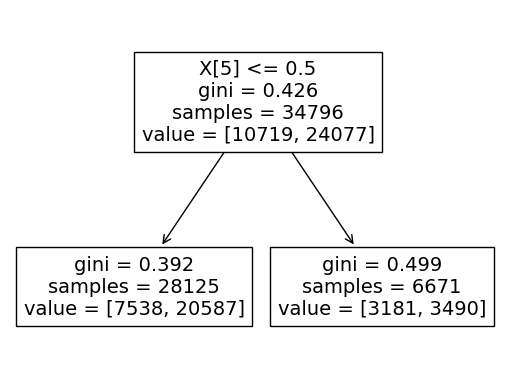

In [35]:
from sklearn import tree
tree.plot_tree(stump)

In [19]:
a, b = y_b.value_counts()
a / (a+b)

0.5944609297725024

Executar o comando com, ao cair a sessão vai salvar um arquivo com o nome 'nohup' (manter o ecomercial no final)

```
nohup <comando> &
```

In [ ]:
nohup <comando> &

In [31]:
X_b.toarray()[:,5].sum()

4321.0

In [8]:
warnings.filterwarnings("ignore")
for j in [0,2,6,7,11]:
    d=datasets[i]
    
# for i,d in enumerate(datasets):
    print('{0: <25}'.format(names[j]), end=" & ")
    
    dset = get_dataset(
        name=d, 
        cache_dir='../tableshift/tmp', 
        use_cached=True
        )
    
    X_a, y_a, _, _ = dset.get_pandas('train')
    # X_a = X_raw_a.toarray() #pipe.fit_transform(X_raw_a)
    # del X_raw_a
    
    model_a = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                    n_estimators=500, max_features="sqrt", 
                                    n_jobs=-1, random_state=2)
    model_a.fit(X_a.values, y_a)
    
    X_id, y_id, _, _ = dset.get_pandas('id_test')
    # X_id = X_raw_id.toarray() # pipe.transform(X_raw_id)
    # del X_raw_id
    
    y_hat_id = model_a.predict(X_id)
    acc_id = accuracy_score(y_id, y_hat_id)
    
    print(f'ID: {acc_id:.03f}', end=" & ")
    
    X_b, y_b, _, _ = dset.get_pandas('ood_test')
    # X_b = X_raw_b.toarray() # pipe.transform(X_raw_b)
    # del X_raw_b
    
    model_b = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                    n_estimators=500, max_features="sqrt", 
                                    n_jobs=-1, random_state=2)
    
    y_hat_b = model_a.predict(X_b.values)
    
    
    model_b.fit(X_b.values, y_hat_b)
    
    dbcp_a = model_a.feature_importances_
    dbcp_b = model_b.feature_importances_
    
    mssf_a = model_a.sufficiency_based_feature_importances(X_a.values)
    mssf_b = model_b.sufficiency_based_feature_importances(X_b.values)
    
    strategy = [dbcp_b, dbcp_b-dbcp_a, mssf_b, mssf_b-mssf_a]
    


ASSISTments               & ID: 0.841 & 

AttributeError: 'numpy.ndarray' object has no attribute 'minmax'

In [21]:
    for i,s in enumerate(strategy):
        if np.isnan(np.sum(s)):
            print (f'In dataset {d}, the strategy {i}, has a NaN')
        # else:
            # print (f'In dataset {d}, the strategy {i} is OK')
        w = (s-s.min())/(s.min()+s.max())
        p = w/w.sum()
        model_adapted_brs = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                                n_estimators=500, max_features="sqrt", 
                                                n_jobs=-1, random_state=2, 
                                                biased_subspaces=True, feature_bias=p)
        
        model_adapted_brs.fit(X_a.values, y_a)
        y_hat = model_adapted_brs.predict(X_b.values)
        acc_ood = accuracy_score(y_b, y_hat)
    
        print(f'{i}: {acc_ood}', end=" & ")
    print()

0: 0.45120671563483733 & 1: 0.43756558237145854 & 2: 0.45120671563483733 & 3: 0.4422875131164743 & 


In [15]:
s

array([0.1105331 , 0.09003226, 0.01596028, 0.01846228, 0.01151075,
       0.0298229 , 0.01939351, 0.04681957, 0.08536923, 0.05744089,
       0.02859757, 0.02586492, 0.01766634, 0.01934042, 0.02044849,
       0.01755729, 0.03268235, 0.02663007, 0.05295865, 0.02400731,
       0.01979818, 0.01597742, 0.01910732, 0.09953909, 0.0152991 ,
       0.07918074])

array([0.81136703, 0.64338776, 0.03645845, 0.05695929, 0.        ,
       0.15004567, 0.06458958, 0.28931263, 0.60517992, 0.37634132,
       0.14000559, 0.11761487, 0.05043758, 0.06415456, 0.07323387,
       0.04954406, 0.17347537, 0.1238844 , 0.33961491, 0.10239402,
       0.0679054 , 0.0365989 , 0.0622446 , 0.72128461, 0.03104094,
       0.55447283])

In [18]:
s.min()

0.0115107462478085

In [3]:


#pc = PreprocessorConfig(categorical_features='one_hot', numeric_features='one_hot')

dset = get_dataset(name='brfss_blood_pressure', # acsfoodstamps
                   cache_dir='../tableshift/tmp',
                   use_cached=True,
                #    preprocessor_config=pc
                  )
df = dset.get_pandas('train')[0]

In [4]:
df

,DRNK_PER_WEEK,DIABETES,AGEG5YR,POVERTY,EMPLOY1_80,EMPLOY1_30,EMPLOY1_20,EMPLOY1_70,EMPLOY1_50,EMPLOY1_nan,...,VEG_ONCE_PER_DAY_nan,SMOKE100_10,SMOKE100_20,SMOKE100_nan,RFBING5_10,RFBING5_20,RFBING5_nan,IYEAR,PRACE1,SEX
0,-0.311024,0.305532,0.014919,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2019.0,1,1
1,-0.311024,-2.904048,-0.497412,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
2,-0.311024,-2.904048,-1.009742,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
3,-0.311024,0.305532,-1.522073,-0.577274,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2021.0,1,1
4,-0.311024,0.305532,-0.497412,1.732280,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2019.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.311024,0.305532,1.039581,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2015.0,1,1
4092,-0.311024,0.305532,1.039581,1.732280,0,0,0,1,0,0,...,0,1,0,0,1,0,0,2015.0,1,0
4093,-0.311024,0.305532,1.551912,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
4094,-0.311024,0.305532,1.551912,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2019.0,0,0


In [3]:

sizes = {'dataset': [],
         'train': [], 
         'validation': [],
         'id_test': [],
         'ood_test':[],
         'ood_validation': []
         }
for d in datasets:
    sizes['dataset'].append(d)
    dset = get_dataset(
        name=d, 
        cache_dir='../tableshift/tmp', 
        use_cached=True
        )

    for s in splits:
        X_, y_, _, _ = dset.get_pandas(s)
        sizes[s].append(X_.shape[0])

df_sizes = pd.DataFrame(sizes)
df_sizes['cum_sum'] = df_sizes.sum(axis=1)
df_sizes.sort_values(by='cum_sum', inplace=True)
df_sizes[splits] = np.divide(df_sizes[splits].values, np.array([df_sizes['cum_sum'].values]*5).T)


cmap=matplotlib.colors.ListedColormap(['#983C2D',
                                       '#B96028', 
                                       '#E2AC48',
                                       '#577575', 
                                       '#A7C5C5'])


FileNotFoundError: [Errno 2] No such file or directory: '../tableshift/tmp\\anesdomain_split_varname_VCF0112domain_split_ood_value_3.0\\info.json'

In [ ]:
dset._initialize_data()
dset.to_sharded(domains_to_subdirectories=True)

In [7]:
del dset
df_sizes

,dataset,train,validation,id_test,ood_test,ood_validation,cum_sum
6,heloc,0.212257,0.026580,0.026580,0.661057,0.073525,10459
2,nhanes_lead,0.429361,0.053675,0.053675,0.416961,0.046329,27499
0,anes,0.518685,0.064828,0.064843,0.316479,0.035164,67085
7,diabetes_readmission,0.344627,0.043078,0.043088,0.512277,0.056929,99493
3,college_scorecard,0.790351,0.098798,0.098798,0.010842,0.001211,124699
5,acsfoodstamps,0.748312,0.093539,0.093540,0.058148,0.006461,840582
8,brfss_blood_pressure,0.255575,0.031946,0.031948,0.612477,0.068053,846761
4,brfss_diabetes,0.671129,0.083891,0.083891,0.144979,0.016109,1444176
10,physionet,0.723033,0.090379,0.090380,0.086588,0.009621,1552210
9,acsincome,0.759461,0.094932,0.094933,0.045606,0.005068,1664500


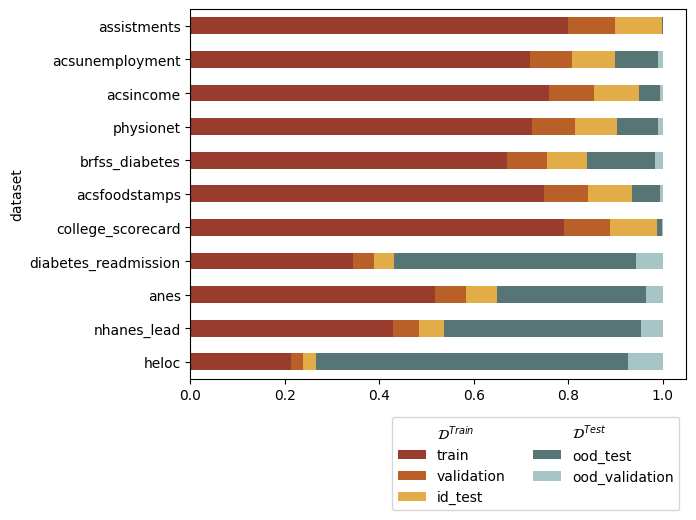

In [86]:

ax = df_sizes.plot(x='dataset', y=splits, kind='barh', stacked=True, cmap=cmap)
h,l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[:1] + h[:3] + ph[1:] + h[3:]
labels = ["$\mathcal{D}^{Train}$"] + l[:3] + ["$\mathcal{D}^{Test}$"] + l[3:]
leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=(1, -0.23),loc='center right')
plt.show()

- FAzer um pseudo codigo de como obter 
- treina o modelo naase A
- treina o modelo na base b
- obtem 
- disponibiizar as fórmulas completas


descobrir o que os que



alta interdependencia em redes neurais

<Axes: ylabel='dataset'>

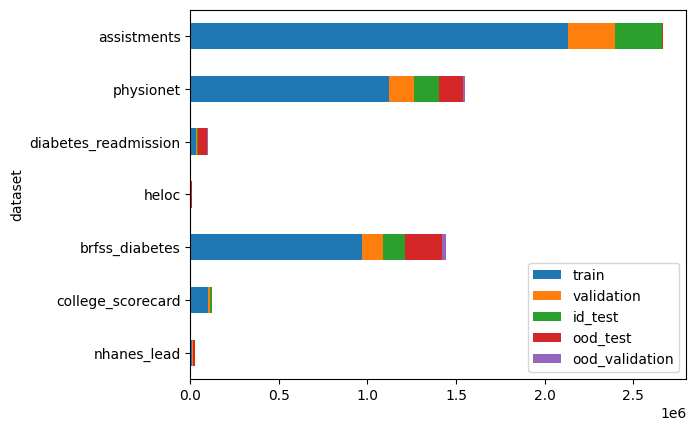

In [10]:
pd.DataFrame(sizes).plot(kind='barh', stacked=True, x = 'dataset')